In [28]:
import os                   # to interact with the operating system
import glob

import numpy as np
import pandas as pd
import xarray as xr

import pop_tools
import gsw                  # compute potential density

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import matplotlib.ticker as ticker

from matplotlib import animation, gridspec

In [29]:
# setting up of regional mask
grid_name = 'POP_gx1v7'
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6, 7, 9]}, 
                             'bounds': {'TLAT': [20., 78.]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}]
} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')

def find_corresponding_number(vvel_filename):
    with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_number_to_find = None
    for filename in vvel_list:
        if filename.split()[1] == vvel_filename:
            vvel_number_to_find = vvel_dict[filename.split()[1]]
            break
    return vvel_number_to_find

def find_corresponding_file_name(vvel_number_to_find):
    with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_filename = None
    for filename in vvel_list:
        if vvel_dict[filename.split()[1]] == vvel_number_to_find:
            vvel_filename = filename.split()[1]  
            break
    return vvel_filename

# Load data from 'events_dens_spg.csv' into a NumPy array.
data = np.genfromtxt('events_dens_spg.csv', delimiter=',', names=True, dtype=None)

# Accessing columns by name
member_numbers = data['Index']
events = data['Values']
member_names = []

for i in range(len(member_numbers)):
    member_names.append(find_corresponding_file_name(member_numbers[i])[5:])

# Plot Composites

In [30]:
ccrs = cartopy.crs

### N_HEAT

In [56]:
n_heat_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/n_heat/n_heat_1001.001.nc'
difference_n_heat = xr.open_dataset(n_heat_file)

#vmin = -abs(difference_n_heat.N_HEAT).max()
#vmax = abs(difference_n_heat.N_HEAT).max()



In [57]:


### for preparatory purposes only
difference_n_heat = difference_n_heat.N_HEAT - difference_n_heat.N_HEAT.isel(time=0)
vmin = -abs(difference_n_heat).max()
vmax = abs(difference_n_heat).max()
###

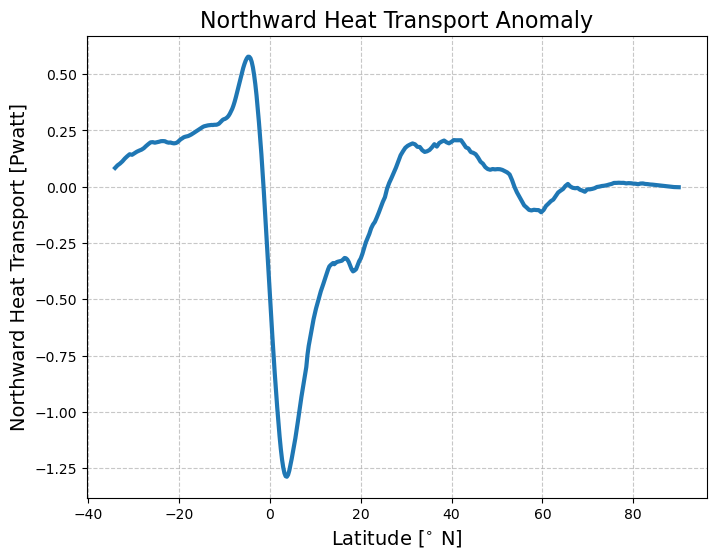

In [70]:
line = difference_n_heat.isel(time=1, transport_reg=1, transport_comp=1).values
#line = difference_n_heat.N_HEAT.isel(time=1, transport_reg=1, transport_comp=1).values
lats = difference_n_heat.lat_aux_grid.values

plt.figure(figsize=(8, 6))
plt.plot(lats, line, linewidth=3)
plt.title('Northward Heat Transport Anomaly', fontsize=16)
plt.xlabel('Latitude [$^{\circ}$ N]', fontsize=14)
plt.ylabel('Northward Heat Transport [Pwatt]', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### AICE

In [71]:
aice_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/aice/aice_1001.001.nc'
difference_aice = xr.open_dataset(aice_file)

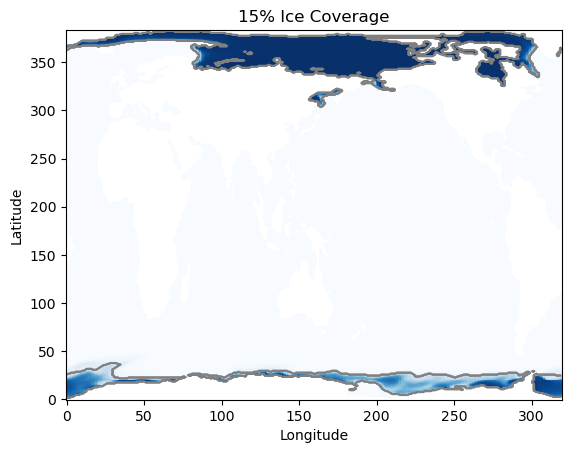

In [85]:
# Assuming ds is your xarray dataset
ice_area = difference_aice.aice.isel(time=0)  # Adjust the variable name accordingly
time_index = 0  # Adjust the time index as needed

# Create a binary mask where True indicates values greater than or equal to 0.15
mask = ice_area >= 0.15

# Plot the map with the 15% ice coverage indicated by a line
fig, ax = plt.subplots()
ice_area.plot(ax=ax, cmap='Blues', add_colorbar=False)
mask.plot.contour(ax=ax, colors=['gray'], linewidths=1)

plt.title(f'15% Ice Coverage')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

### BSF

In [11]:
vvel_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/vvel/vvel_1001.001.nc'
difference_vvel = xr.open_dataset(vvel_file)

difference_vvel = difference_vvel.isel(time=0).where(mask3d == 1).roll(nlon=-100)

In [12]:
def BSF(ds):
    
    ## compute barotropic streamfunction
    bsf_ds = (ds.VVEL * ds.dz * ds.DXU).sum(dim='z_t').cumsum(dim='nlon')

    return bsf_ds

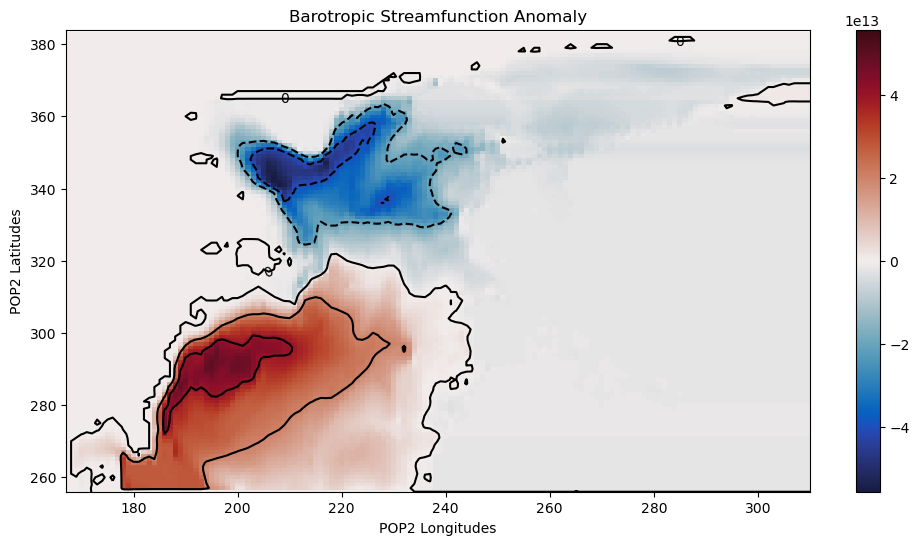

In [46]:
field = BSF(difference_vvel)

cmap = cmo.balance
#cmap.set_bad('gray')

plt.figure(figsize=(12, 6))
horiz_sigma_plot = field.plot(cmap=cmap)#, vmin=vmin_sigma, vmax=vmax_sigma)
contour_sigma = field.plot.contour(colors='k') 
plt.clabel(contour_sigma, inline=False, fontsize=10)

plt.xlim([167, 310])
plt.ylim([256, 384])

plt.ylabel('POP2 Latitudes')
plt.xlabel('POP2 Longitudes')
plt.title('Barotropic Streamfunction Anomaly')
plt.show()

### DEPTH MOC

In [47]:
def depth_MOC(ds):
    
    ### compute overturning in depth space
    overturning_ds = (ds.VVEL * ds.dz * ds.DXU).sum(dim='nlon').cumsum(dim='z_t')

    return overturning_ds

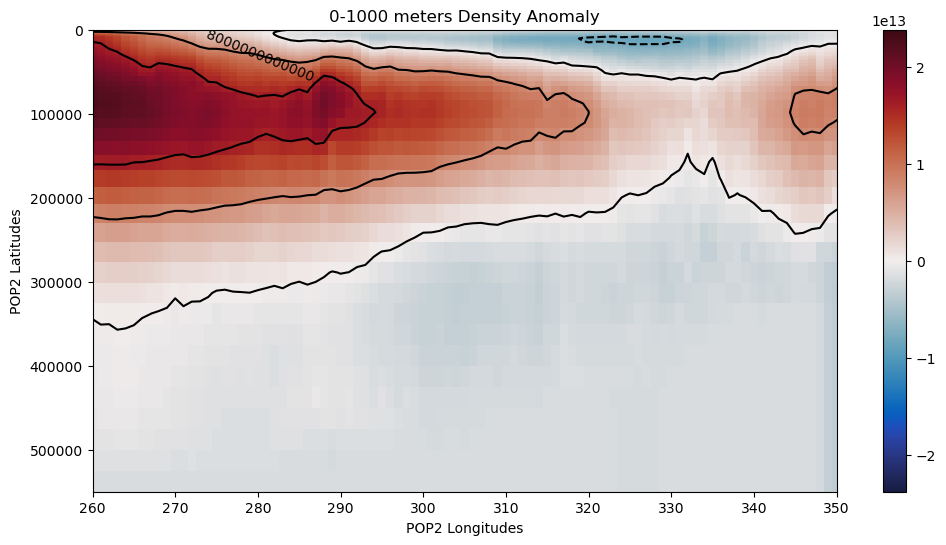

In [48]:
field = depth_MOC(difference_vvel)

cmap = cmo.balance
cmap.set_bad('gray')

plt.figure(figsize=(12, 6))
horiz_sigma_plot = field.plot(cmap=cmap, yincrease = False)#, vmin=vmin_sigma, vmax=vmax_sigma)
contour_sigma = field.plot.contour(colors='k', yincrease = False) 
plt.clabel(contour_sigma, inline=False, fontsize=10)

plt.xlim([260, 350])
plt.ylabel('Depth')
plt.xlabel('POP2 Latitudes')
plt.title('Depth Overturning Anomaly')
plt.show()

### DENSITY MOC

In [31]:
dens_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_1231.001.nc'
ds = xr.open_dataset(dens_file)

In [37]:
sigma_per1 = ds.SIGMA_2.isel(time=0)
sigma_per2 = ds.SIGMA_2.isel(time=1)
vvel_per1 = ds.VVEL.isel(time=0)
vvel_per1 = ds.VVEL.isel(time=1)

In [106]:
sigma_level = [12. , 16. , 20. , 24. , 28. , 28.5 , 29.2 , 29.4 , 29.6 , 29.8 , 30. , 30.2 , 30.4 , 30.6 , 
                       30.8 , 31. , 31.2 , 31.4 , 31.6 , 31.8 , 32. , 32.2 , 32.4 , 32.6 , 32.8 , 33. , 33.2 , 33.4 , 
                       33.6 , 33.8 , 34. , 34.2 , 34.4 , 34.6 , 34.8 , 35. , 35.2 , 35.4 , 35.6 , 35.8 , 36.1 , 36.2 , 
                       36.3 , 36.4 , 36.55, 36.6 , 36.65, 36.7 , 36.72, 36.74, 36.76, 36.78, 36.8 , 36.82, 36.84, 
                       36.86, 36.88, 36.9 , 36.92, 36.94, 36.96, 36.98, 37. , 37.02, 37.04, 37.06, 37.08, 37.1 , 
                       37.12, 37.14, 37.16, 37.18, 37.2 , 37.25, 37.3 , 37.35, 37.4 , 37.45, 37.6 , 37.7 , 37.8 , 
                       37.9 , 38. , 39. , 40. , 41. , 42.]

def density_MOC(ds_vvel, ds_sigma, ds):

    # define range on pop-grid
    min_lat=250
    max_lat=360
    
    overturning = np.zeros([len(sigma_level), (max_lat-min_lat)])

    for j in range(min_lat,max_lat):
        # prepare transport array
        sigma_transport = np.zeros(len(sigma_level))

        ### compute velocity transport
        v_transport = (ds_vvel.isel(nlat=j) * ds.dz.isel(nlat=j) * ds.DXU.isel(nlat=j)).values

        ### get sigma vlaues for selected cross section
        sigma_crossection = ds_sigma.isel(nlat=j).values

        ### sum over longitudes per sigma bin
        for i in range(len(sigma_level)-1):
            ind = np.where((sigma_crossection >= sigma_level[i]) & (sigma_crossection < sigma_level[i+1]))
            sigma_transport[i] = np.nansum(v_transport[ind])

        ## compute overturning
        overturning[:,j-min_lat] = np.cumsum(sigma_transport)[::-1]
        overturning[:,j-min_lat] = overturning[:,j-min_lat][::-1]
        
    overturning_ds = xr.Dataset({'densMOC': (['sigma', 'nlat'], overturning)})

    overturning_ds['sigma'] = sigma_level
    overturning_ds['nlat'] = ds.nlat.isel(nlat = slice(min_lat, max_lat))

    return overturning_ds.densMOC



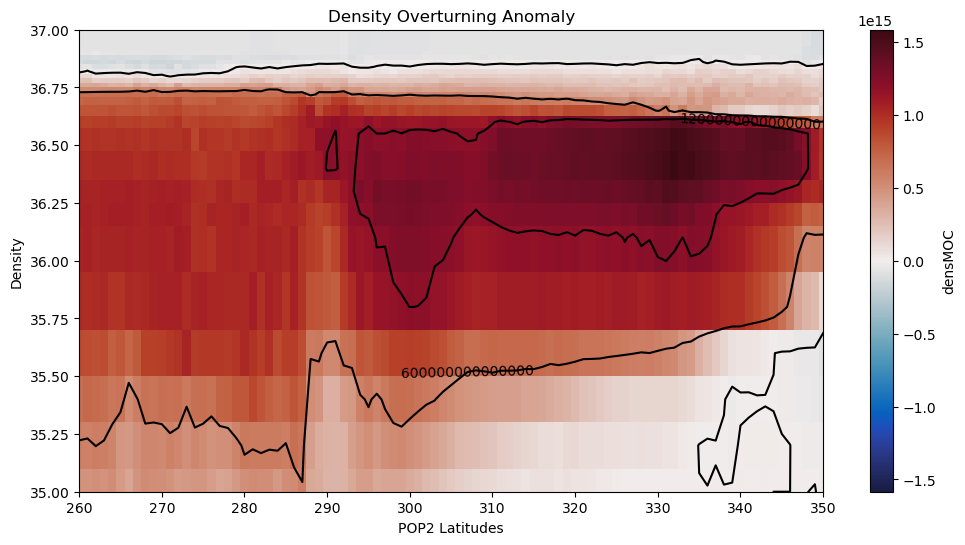

In [107]:
field = density_MOC(vvel_per1, sigma_per1, ds)

cmap = cmo.balance
cmap.set_bad('gray')

plt.figure(figsize=(12, 6))
horiz_sigma_plot = field.plot(cmap=cmap)#, yincrease = False)#, vmin=vmin_sigma, vmax=vmax_sigma)
contour_sigma = field.plot.contour(colors='k')#, yincrease = False) 
plt.clabel(contour_sigma, inline=False, fontsize=10)

plt.xlim([260, 350])
plt.ylim(35,37)

plt.ylabel('Density')
plt.xlabel('POP2 Latitudes')
plt.title('Density Overturning Anomaly')
plt.show()

### DENS

In [3]:
sigma_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/sigma_anomaly.nc'
difference_sigma = xr.open_dataset(sigma_file)
vmin = -abs(difference_sigma.SIGMA_2).max()
vmax = abs(difference_sigma.SIGMA_2).max()

Text(0.5, 1.0, '0-1000 meters Density Anomaly')

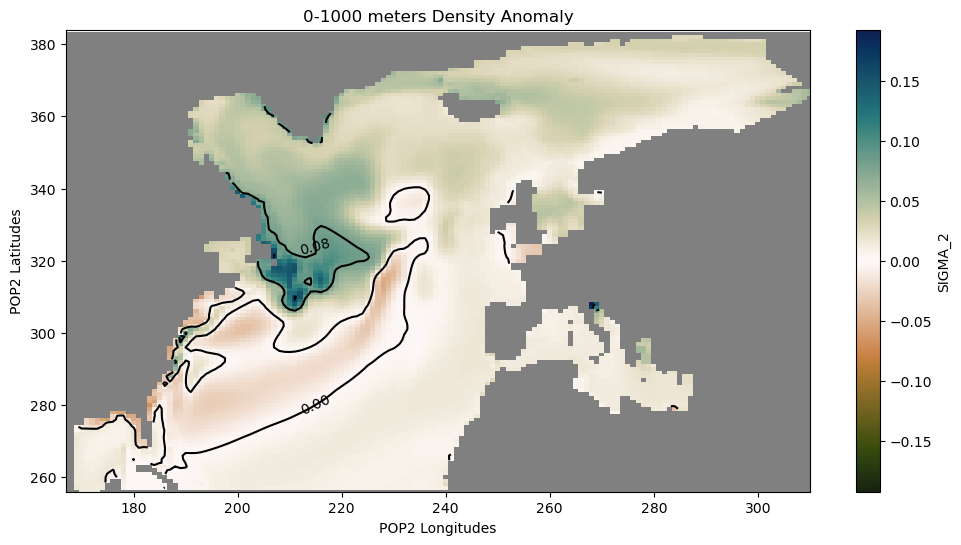

In [4]:
field = difference_sigma.SIGMA_2.sel(z_t=slice(5.0000000e+02, 8.7882523e+04)).mean('z_t')

cmap = cmo.tarn
cmap.set_bad('gray')

plt.figure(figsize=(12, 6))
horiz_sigma_plot = field.plot(cmap=cmo.tarn)#, vmin=vmin_sigma, vmax=vmax_sigma)
contour_sigma = field.plot.contour(colors='k') 
plt.clabel(contour_sigma, inline=False, fontsize=10)

plt.xlim([167, 310])
plt.ylim([256, 384])
plt.ylabel('POP2 Latitudes')
plt.xlabel('POP2 Longitudes')
plt.title('0-1000 meters Density Anomaly')
plt.show()

#### latitudinal section

In [5]:
cmap = cmo.tarn
cmap.set_bad('gray')

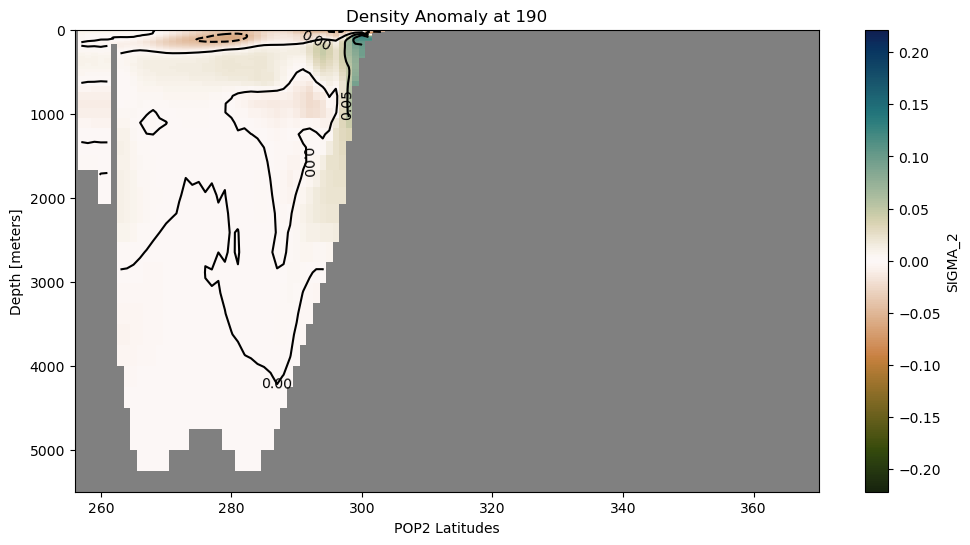

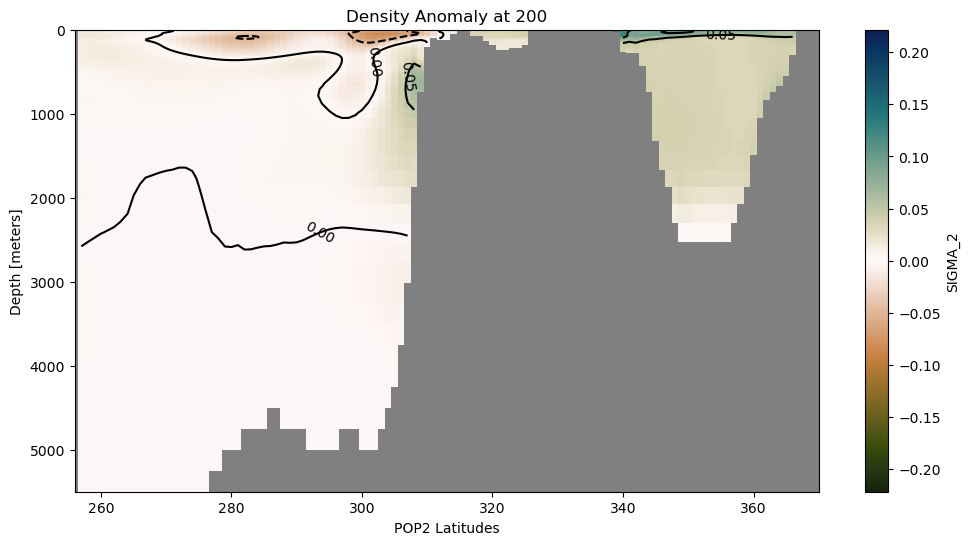

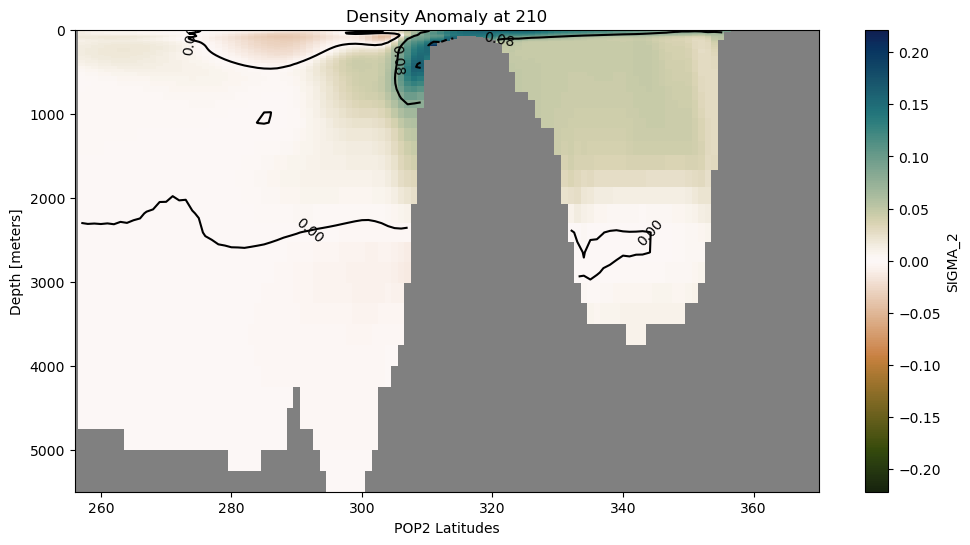

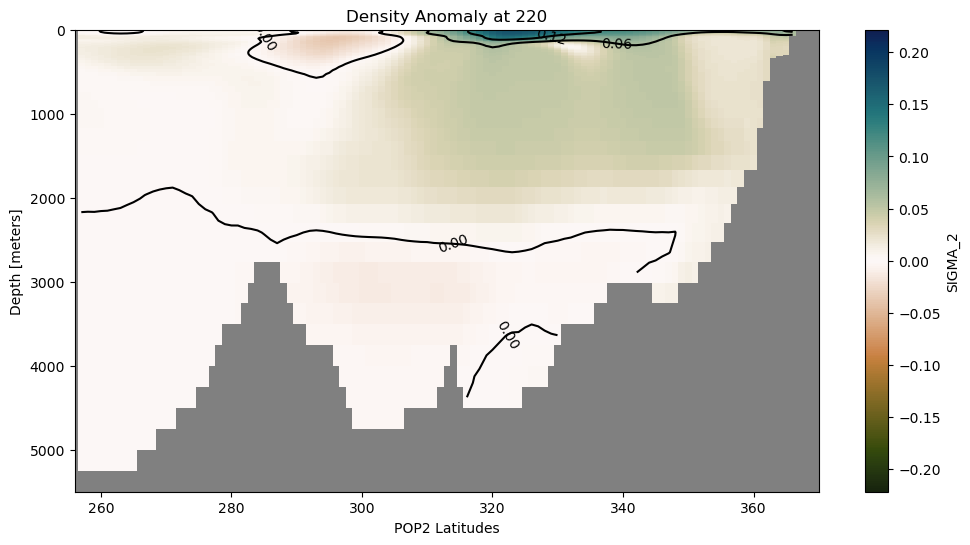

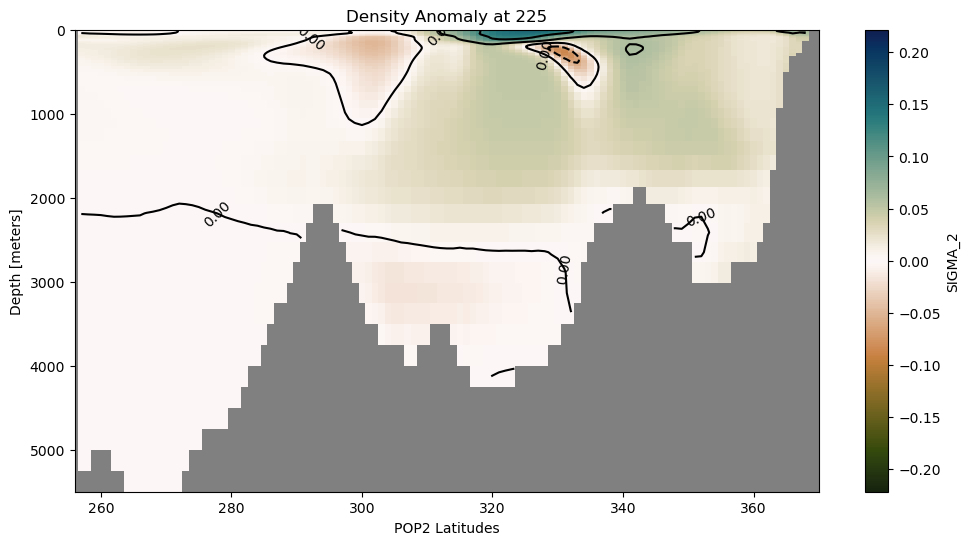

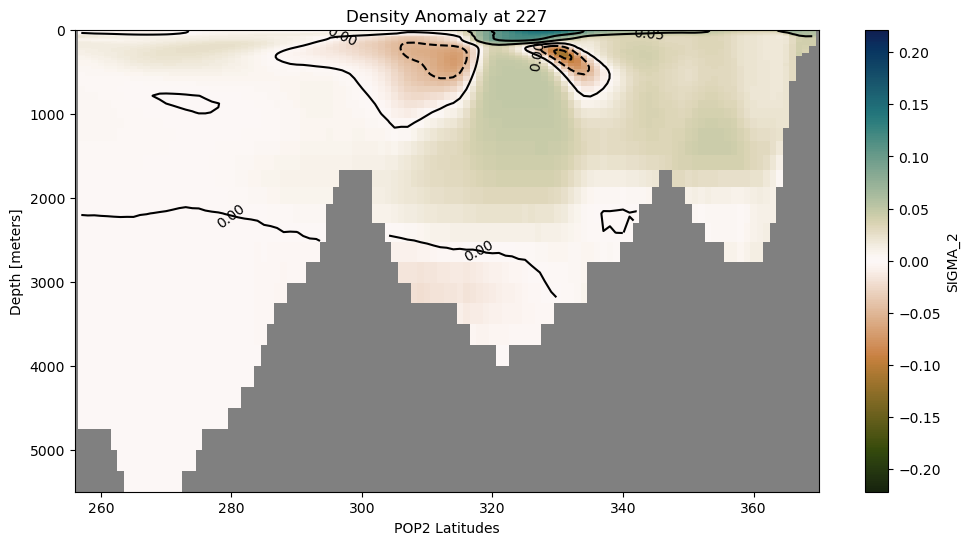

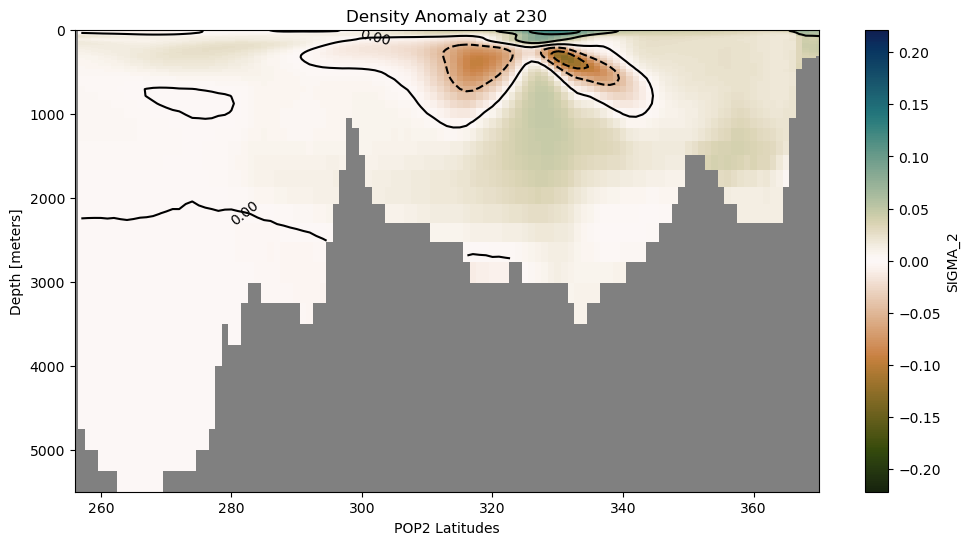

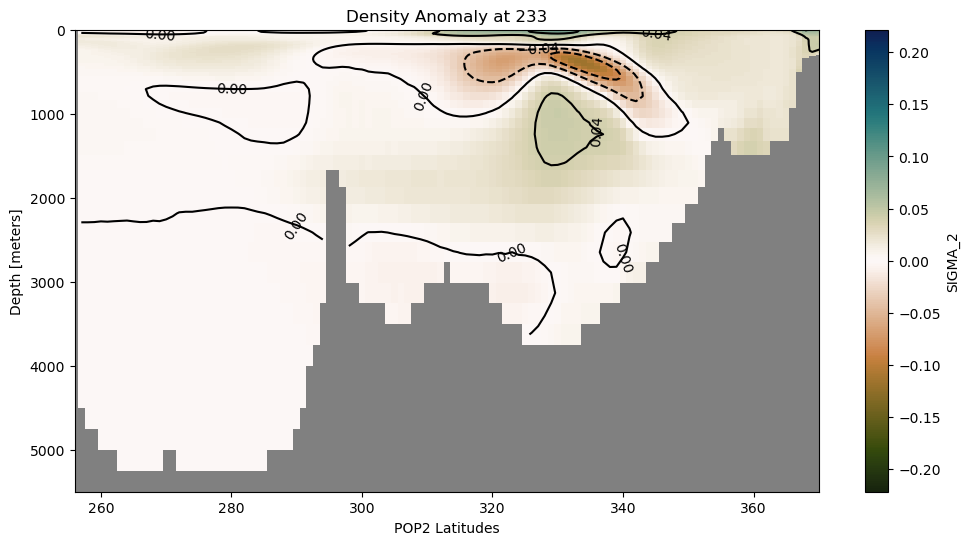

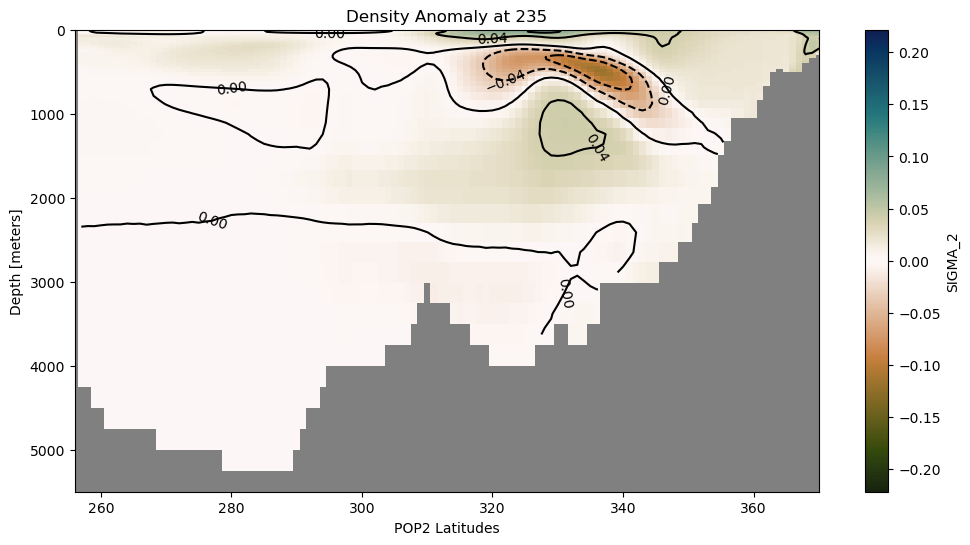

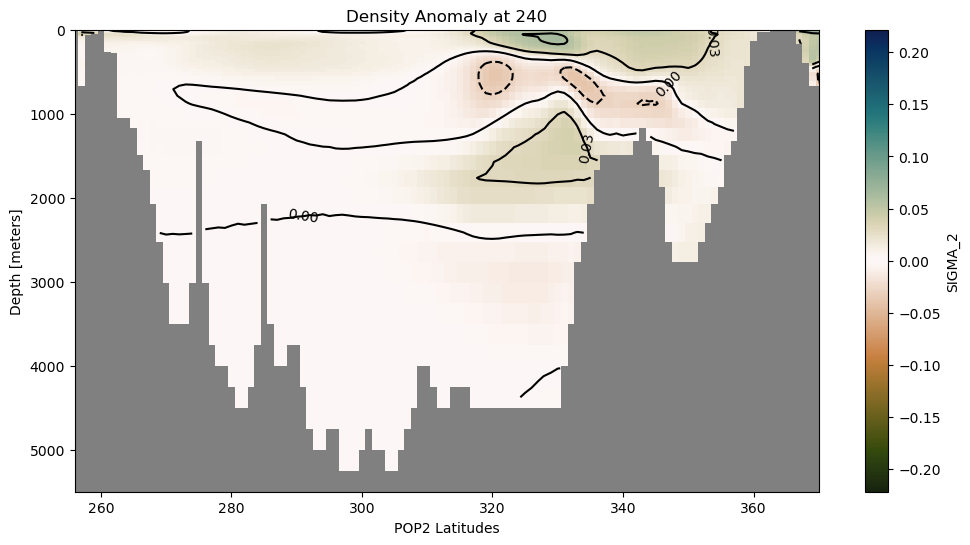

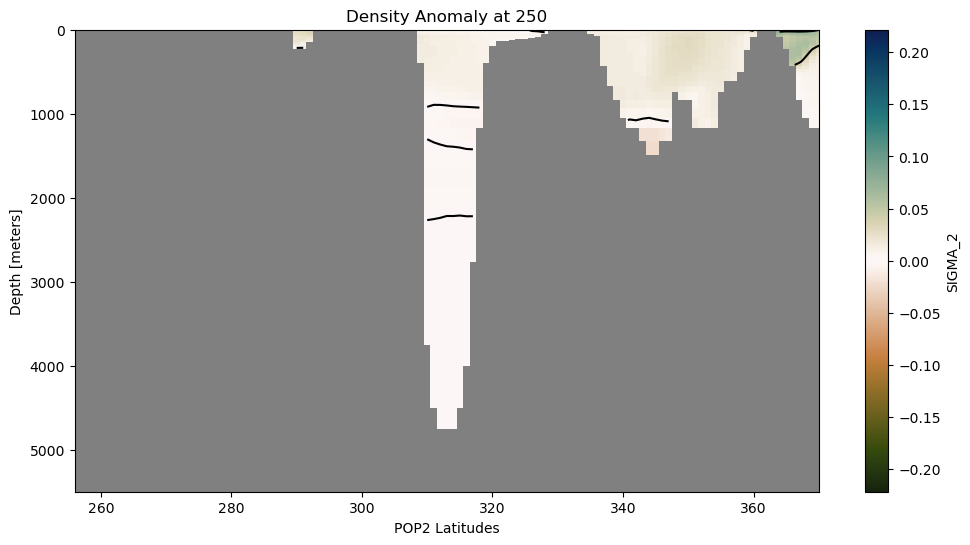

In [6]:
nlons = [190, 200, 210, 220, 225, 227, 230, 233, 235, 240, 250]

for nlon in nlons:
    field = difference_sigma.SIGMA_2.isel(nlon=nlon)


    plt.figure(figsize=(12, 6))
    lati_sigma_plot = field.plot(cmap=cmap,yincrease=False, vmin=vmin, vmax=vmax)
    contour = field.plot.contour(colors='k') 
    plt.clabel(contour, inline=False, fontsize=10)

    plt.xlim([256, 370])
    plt.ylabel('Depth [meters]')
    plt.xlabel('POP2 Latitudes')
    plt.title('Density Anomaly at '+str(nlon))

    plt.gca().invert_yaxis()
    new_y_labels = ['0','1000', '2000', '3000', '4000', '5000']
    plt.yticks([0,100000, 200000, 300000, 400000, 500000], labels=new_y_labels)

    #plt.show()
    plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'sigma_anomaly-'+str(nlon)+'.png', bbox_inches='tight', dpi=300)

# Plot average years

In [7]:
files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/*.nc'))

In [65]:
variables = ['TEMP', 'SALT', 'SIGMA_2', 'HMXL', 'SHF', 'SSH']
labels = [r'Temperature Anomaly $\Delta T$ [$^{\circ} C$]', r'Haline Anomaly $Delta S$ [$\frac{g}{kg}$]', 
          r'Potential Density Anomaly $\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]', r'March Mixed Layer Depth Anomaly $\Delta h$ [$m$]',
          r'Total Surface Heat Flux Anomaly $\Delta Q_s$ [$\frac{W}{m^2}$]', r'Sea Surface Height Anomaly $\Delta \eta$ [$m$]']

cmaps = [cmo.balance, cmo.delta, cmo.tarn, cmo.diff, cmo.curl, cmo.diff]

for var in variables:

    var_years = []
    for t in range(60):
        var_year = []
        for i in range(len(files)):
            try:
                ds = xr.open_dataset(files[i])
            except ValueError as e:
                continue

            ds_file = ds[var].isel(time=t)
            var_year.append(ds_file)

        ds_comp = xr.concat(var_year, dim='file').mean(dim='file')
        var_years.append(ds_comp)

    ds_var_annual = xr.concat(var_years, dim='time')
    
    break

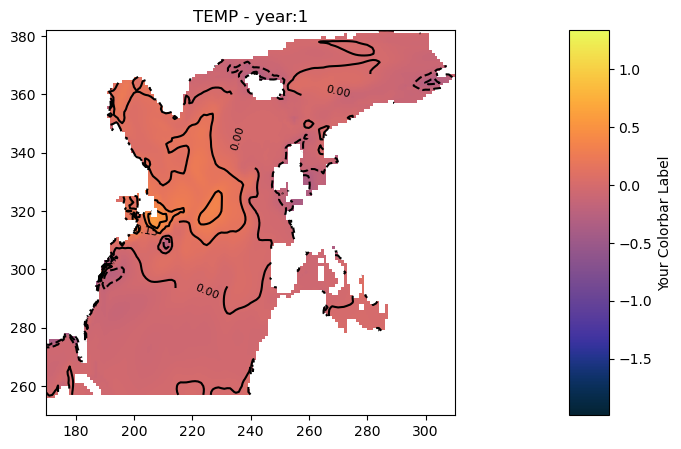

In [63]:
def plot_var_frame(time_step):
    data = ds.isel(time=start + time_step)
    ax1.cla()
    im = ax1.imshow(data, cmap=cmo.thermal, vmin=t_min, vmax=t_max)  ## TEMPERATURE colormap
    contour = ax1.contour(data, colors='k')
    ax1.clabel(contour, inline=True, fontsize=8)
    ax1.set_xlim([170, 310])
    ax1.set_ylim([250, 382])
    ax1.set_title(var+f' - year:{1+time_step}')

# Set up initial data
start = 1
ds = ds_var_annual.sel(z_t=slice(5.0000000e+02, 8.7882523e+04)).mean('z_t') - ds_var_annual.isel(time=0).sel(z_t=slice(5.0000000e+02, 8.7882523e+04)).mean('z_t')
t_min, t_max = ds.min().values, ds.max().values

# create figure and set up layout of subplots
fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[13, 1])

# main subplot for animation
ax1 = plt.subplot(gs[0])

# Acolorbar subplot 
cax = plt.subplot(gs[1])
num_time_steps = 59
ani = animation.FuncAnimation(fig, plot_var_frame, frames=num_time_steps, interval=800)

# set colorbar
sm = plt.cm.ScalarMappable(cmap=cmo.thermal, norm=plt.Normalize(vmin=t_min, vmax=t_max))
sm.set_array([])  # empty array for now
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Your Colorbar Label')

# Save animation
ani.save(os.path.expanduser('~/phase1_CONDA/results/') + 'test.gif', writer='pillow', fps=3)


# Plot average decades

In [41]:
# Retrieve colorbar label from the xarray dataset
colorbar_label = ds.attrs.get('long_name')
colorbar_label

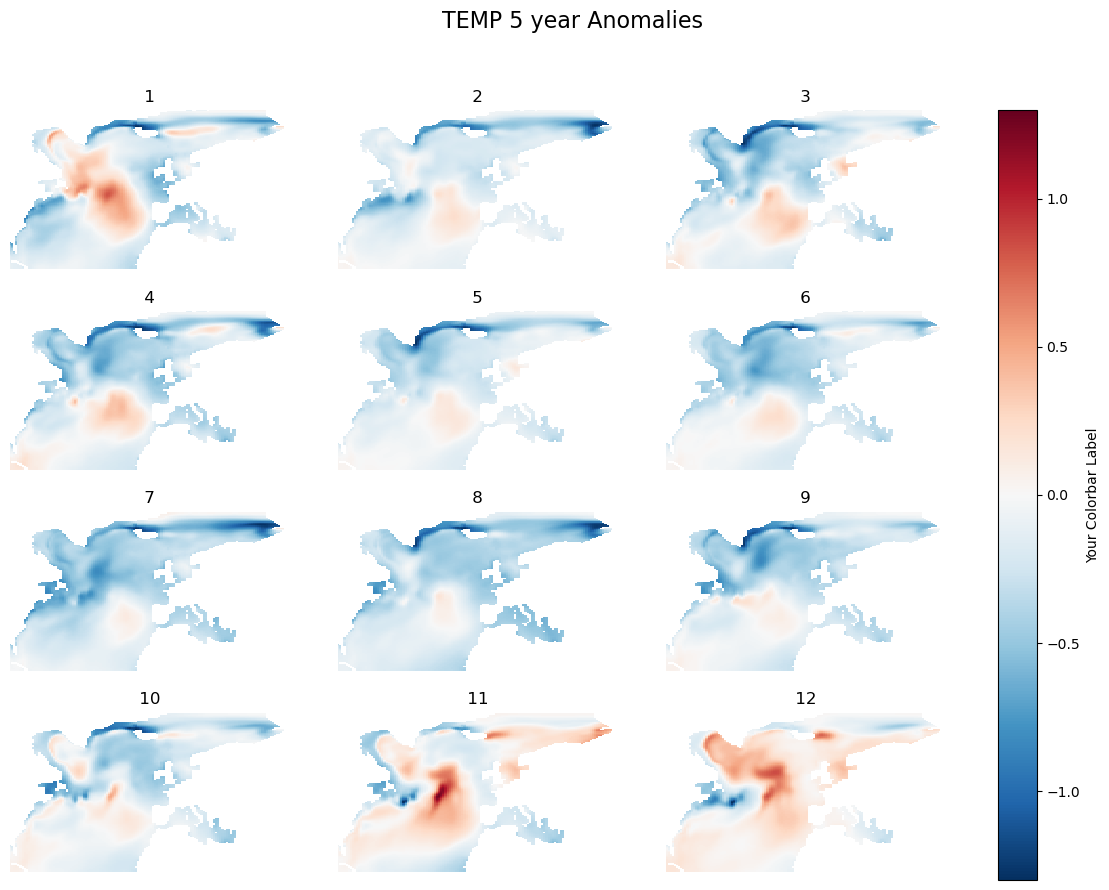

In [42]:
ds = ds_var_annual.isel(z_t=0) - ds_var_annual.isel(z_t=0, time=0)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))

# Set common xlim and ylim for all plots
common_xlim = (180, 310)
common_ylim = (250, 380)

# Loop through the subplots and plot the data
for i, ax in enumerate(axes.flatten()):
    # Plot data without colorbar
    plot = ds.isel(time=range(i * 5, i * 5 + 5)).mean('time').plot(ax=ax, add_colorbar=False)
    ax.set_axis_off()

    # Set xlim and ylim
    ax.set_xlim(common_xlim)
    ax.set_ylim(common_ylim)

    ax.set_title(f" {i+1}")

# Add a single colorbar for all plots outside the loop
cbar = fig.colorbar(plot, ax=axes, orientation='vertical', label='Your Colorbar Label')

fig.suptitle(var+' -  5 year Anomalies', fontsize=16)

plt.show()

# Plot average 5 years@

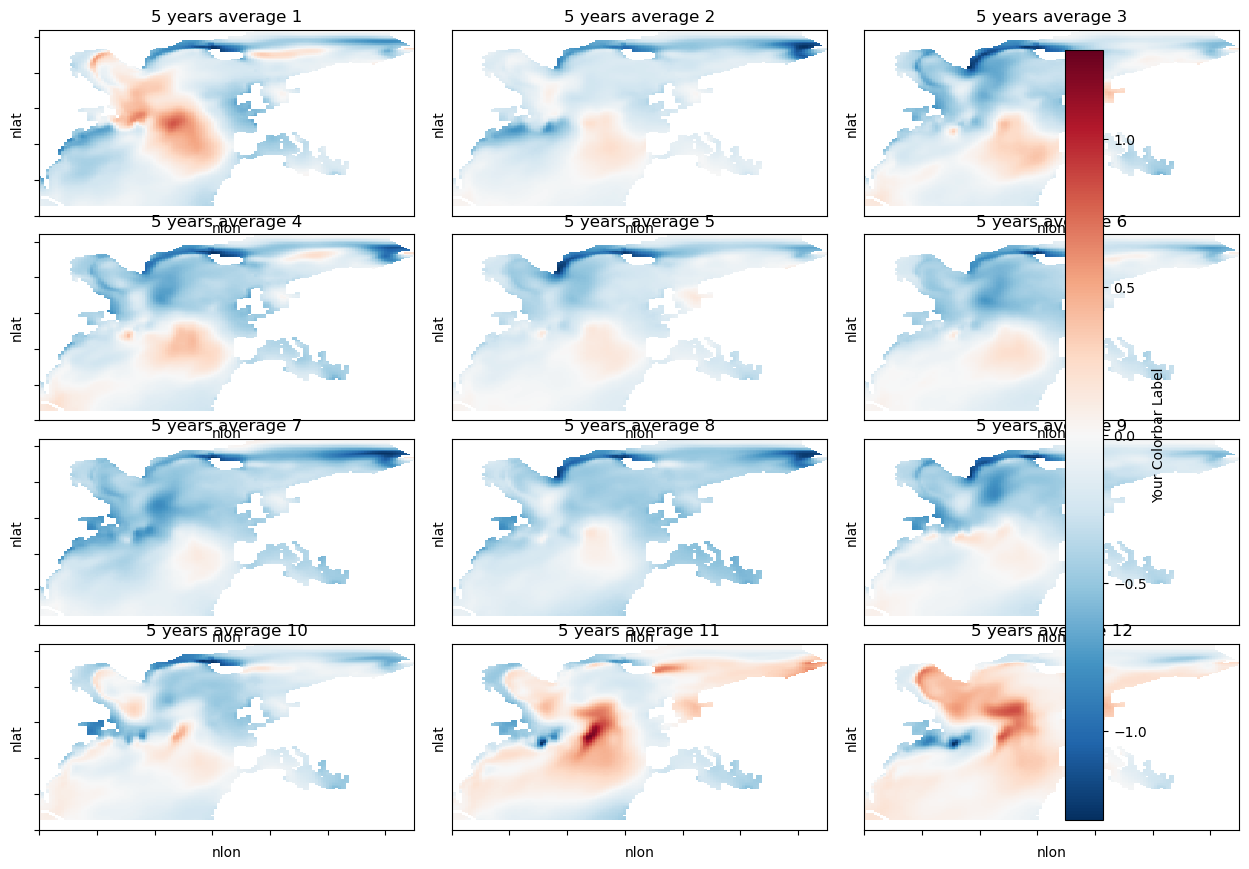

In [33]:
# Your existing code
ds = ds_var_annual.isel(z_t=0) - ds_var_annual.isel(z_t=0, time=0)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), sharex=True, sharey=True)

# Set common xlim and ylim for all plots
common_xlim = (180, 310)
common_ylim = (250, 380)

# Loop through the subplots and plot the data
for i, ax in enumerate(axes.flatten()):
    # Plot data without colorbar
    plot = ds.isel(time=range(i * 5, i * 5 + 5)).mean('time').plot(ax=ax, add_colorbar=False)

    # Set xlim and ylim
    ax.set_xlim(common_xlim)
    ax.set_ylim(common_ylim)

    ax.set_title(f"5 years average {i+1}")

    # Remove ticks and labels from inner plots
    if i % 3 != 0:
        ax.set_yticklabels([])  # Hide y-axis tick labels
        ax.tick_params(left=False)
    if i < 9:
        ax.set_xticklabels([])  # Hide x-axis tick labels
        ax.tick_params(bottom=False)

# Add a single colorbar for all plots outside the loop
cbar = fig.colorbar(plot, ax=axes, orientation='vertical', label='Your Colorbar Label')

# Adjust layout manually
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1)

plt.show()